<a href="https://colab.research.google.com/github/GeorgiaWensell/Blue_Crabs_Repository/blob/main/Fishing_Lin_vs_Hyp_Blue_Crab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
### Linear Fishing ###

from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns


#Winter Parameters
#m_wj = Natural mortality of juveniles in winter
#m_wa = Natural mortality of adults in winter
#d_w = Disease related mortality in winter

#Define winter rates of change
def deriv_w(w,t,m_wj,m_wa,d_w): #w is the vector [J_S,J_I,A_S,A_I,H]; t is time
  J_S, J_I, A_S, A_I, H = w
  dJ_S = - m_wj*J_S
  dJ_I = - m_wj*J_I - d_w*J_I
  dA_S = - m_wa*A_S
  dA_I = - m_wa*A_I - d_w*A_I
  dH = 0
  return [dJ_S,dJ_I,dA_S,dA_I,dH]

#Spring Parameters
#p = Density of predators
#k_s = Maximum feeding rate in spring
#Gamma = Raised susceptibility of infected juveniles to cannibalism and predation
#J_x = Prey density at half of maximum feeding rate
#d_s = Disease related mortality in spring
#m_sa = Natural mortality of adults in spring
#f_ah = maximum fishing mortality rate
#f_al = linear fishing mortality rate
#s = adult density at half of the maximum fishing rate
#c_sj = Juvenile infection rate in spring
#c_sa = Adult infection rate in spring
#r_j = Dinospore shedding rate for juveniles
#r_a = Dinospore shedding rate for adults
#Delta = Dinosopore removal rate
#x = percentage of adult infecteds still fished

#Fishing functions, (used in both Spring and Fall)
def fishing_hyp(t,A_S,A_I,f_ah,s):
  A_all = A_S+A_I
  F_H = (f_ah * A_all)/(1+ s*A_all)
  return F_H

def fishing_lin(t, A_S, A_I, f_al, s):
  A_all = A_S+A_I
  F_L = (f_ah*A_all)/(s+A_all)
  return F_L

#Define spring rates of change
def deriv_s(w,t,p,k_s,Gamma,J_x,d_s,m_sa,f_ah,f_al,s,c_sj,c_sa,r_j,r_a,Delta):
  J_S, J_I, A_S, A_I, H = w   #Again, w is the vector [J_S,J_I,A_S,A_I,H]; t is time
  dJ_S = - (p + A_S + A_I)*(k_s*(J_S + Gamma*J_I))/(J_x**2 + (J_S + Gamma*J_I)**2)*J_S - c_sj*J_S*H#in spring, change back to H as just H, death rate from OG model above, shouldn't be a function, get rid of g(H) in H'
  dJ_I = - (p + A_S + A_I)*(k_s*(J_S + Gamma*J_I))/(J_x**2 + (J_S + Gamma*J_I)**2)*Gamma*J_I + c_sj*J_S*H - d_s*J_I #go back to linear transmission as well??
  dA_S = - m_sa*A_S - fishing_lin(t,A_S,A_I,f_al,s)*(A_S)/(A_S + A_I) - c_sa*A_S*H
  dA_I = - m_sa*A_I - fishing_lin(t,A_S,A_I,f_al,s)*(A_I*(1-x))/(A_S + A_I) + c_sa*A_S*H - d_s*A_I
  dH = r_j*J_I + r_a*A_I - Delta*H
  return [dJ_S,dJ_I,dA_S,dA_I,dH]

#Fall Parameters
#p = Density of predators
#k_f = Maximum feeding rate in fall
#Gamma = Raised susceptibility of infected juveniles to cannibalism and predation
#J_x = Prey density at half of maximum feeding rate
#d_f = Disease related mortality in fall
#m_fa = Natural mortality in fall
#f_ah = maximum fishing mortality rate
#f_al = linear fishing mortality rate
#s = adult density at half of the maximum fishing rate
#c_fj = Juvenile infection rate in fall
#c_fa = Adult infection rate in fall
#r_j = Dinospore shedding rate for juveniles
#r_a = Dinospore shedding rate for adults
#Delta = Dinosopore removal rate
#alpha = maximum per capita reproduction rate
#beta = density-dependent effect on reproduction
#x = percentage of adult infecteds still fished

#Recruitment function
def recruitment(t,A_S, A_I,alpha,beta):
  #total_recruits = (alpha*A_S) / (1+b*A_S**2) , the Ricker function version
  A_all = A_S+A_I
  total_recruits = (alpha*(A_all))/(beta+(A_all)) #hyperbolic, what we use
  rec_distributed = total_recruits / t_f
  return rec_distributed

#Define fall rates of change
def deriv_f(w,t,p,k_f,Gamma,J_x,d_f,m_fa,f_ah,f_al,s,c_fj,c_fa,r_j,r_a,Delta,alpha,beta):
  J_S, J_I, A_S, A_I, H = w    #Again, w is the vector [J_S,J_I,A_S,A_I,H]; t is time
  dJ_S = recruitment(t,A_S,A_I,alpha,beta) - (p + A_S + A_I)*(k_f*(J_S + Gamma*J_I))/(J_x**2 + (J_S + Gamma*J_I)**2)*J_S - c_fj*J_S*H
  dJ_I = - (p + A_S + A_I)*(k_f*(J_S + Gamma*J_I))/(J_x**2 + (J_S + Gamma*J_I)**2)*Gamma*J_I + c_fj*J_S*H - d_f*J_I
  dA_S = - m_fa*A_S - fishing_lin(t,A_S,A_I,f_al,s)*(A_S)/(A_S + A_I) - c_fa*A_S*H
  dA_I = - m_fa*A_I - fishing_lin(t,A_S,A_I,f_al,s)*(A_I*(1-x))/(A_S + A_I) + c_fa*A_S*H - d_f*A_I
  dH = r_j*J_I + r_a*A_I - Delta*H
  return [dJ_S,dJ_I,dA_S,dA_I,dH]

#Functions to generate disease prevalence graphs
def safe_J_percent(J_S, J_I): #Prevalence for juveniles
    mask = (J_S + J_I) != 0 # Check if denominator (J_S + J_I) is zero
    # Calculate J_I percent only for non-zero denominator elements
    J_percent = np.zeros_like(J_I)
    J_percent[mask] = J_I[mask] / (J_S[mask] + J_I[mask])
    return J_percent

def safe_A_percent(A_S, A_I): #Prevalence for adults
    mask = (A_S + A_I) != 0
    A_percent = np.zeros_like(A_I)
    A_percent[mask] = A_I[mask] / (A_S[mask] + A_I[mask])
    return A_percent


TotalJ_S = [] #Empty lists, will hold all of the variable values and the time steps for graphing
TotalJ_I = []
TotalA_S = []
TotalA_I = []
TotalH_L = []
Total_time = []
TotalJ_percent_L = []
TotalA_percent_L = []
Season_transitions = []

t_w = 151/365 #Proportion of days out of the year in each season (w=winter, s=spring, f=fall)
t_s = 91/365
t_f = 123/365
num_seasons = 3  #Number of seasons in a year
season_lengths = [t_w, t_s, t_f]  #Duration of each season
season_ends = [0, t_w, (t_w + t_s)] #End of each season interval, used for time steps and initial conditions
years = 50 #Number of years simulated

for year in range(years):
    #Calculation of time steps and season transitions
    for season in range(num_seasons):
      t = year + season_ends[season]
      time = np.linspace(t, t + season_lengths[season], 200)  # Time range for each season
      time2 = [t, t + season_lengths[season]] # Time range for each season

      #Winter initial conditions
      if season == 0 and t == 0: #First year, first winter (year 0) initial conditions
        w0 = [1.4954160801296652, 10.01313319909174, 0.11611118423767798, 1.3643661339726547, 0]
      elif season == 0 and t != 0: #Continuity during the winter season, as well as initial conditions for year 1, year 2, year 3,... winters
        w0 = [J_S[-1], J_I[-1], A_S[-1], A_I[-1], 0]

      #Spring initial conditions
      elif season == 1 and (t - year) == t_w:
        w0 = [J_S[-1], J_I[-1], A_S[-1], A_I[-1], 0]
        Season_transitions.append(t)
      elif season == 1 and (t - year) != t_w: #Continuity during the spring season
        w0 = [J_S[-1], J_I[-1], A_S[-1], A_I[-1], H[-1]]
        Season_transitions.append(t)

      #Fall initial conditions
      elif abs(t - year - season_ends[1]) >= 1e-17 and season == 2:
        w0 = [0, 0, A_S[-1]+J_S[-1], A_I[-1]+J_I[-1], H[-1]]
        Season_transitions.append(t)
      elif season == 2 and (t - year) != season_ends[1]: #Continuity during the fall season
        w0 = [J_S[-1], J_I[-1], A_S[-1], A_I[-1], H[-1]]
        Season_transitions.append(t)

      #Parameter input:
      #Winter:
      m_wj=0.9
      m_wa=0.9
      d_w=0.0718156732891 #either 0.74 for colder or 0.07 for warmer - determines if 1 or 2 cycles
      #graph of period change of theta and d_w shown in paper, maybe make this figure better
      #should be figure, not just dot, dw small = 1 period, dw large and theta small = 2 period
      #wants it to look like areas with roman numerals in diff colored polygon areas(I or II to show period type), show a curve to separate the regions

      #Spring:
      p=20
      k_s=5
      Gamma=0.8
      J_x=80
      m_sa=0.9
      f_ah= 0.5362 #new f for hyp 2, 37/69
      f_al=0.294 #f for lin
      s=0.0145 #new s for hyp 2, 1/69
      c_sj=2.5
      c_sa=1.3
      r_j=.9125
      r_a=328.5
      Delta=182.5
      d_s=8.151
      x=0.1

      #Fall:
      p=20
      k_f=5
      Gamma=0.8
      J_x=80
      d_f=11.114
      m_fa=0.9
      f_ah= 0.5362 #new f for hyp 2, same as spring
      f_al=0.294 #f for lin, same as spring
      s=0.0145 #new s for hyp 2, same as spring
      c_fj=22
      c_fa=1.7
      r_j=.9125
      r_a=328.5
      Delta=182.5
      alpha=122.388
      beta=0.3143
      x=0.1

      #Solve system of ODEs
      if (t - year) >= 0 and (t - year) <= t_w and season == 0: #Winter seasons (i.e. t = [0,t_w], [1,1+t_w], [2,2+t_w]...)
          wsol = odeint(deriv_w,w0,time,args=(m_wj,m_wa,d_w))  #Solve winter ODE
          J_S, J_I, A_S, A_I, H = wsol.T
          J_percent = safe_J_percent(J_S, J_I) #Calculate disease prevalences
          A_percent = safe_A_percent(A_S, A_I)
          J_S = np.ndarray.tolist(J_S) #Turn arrays into lists so we can concatenate
          J_I = np.ndarray.tolist(J_I)
          A_S = np.ndarray.tolist(A_S)
          A_I = np.ndarray.tolist(A_I)
          H = np.ndarray.tolist(H)
          J_percent = np.ndarray.tolist(J_percent)
          A_percent = np.ndarray.tolist(A_percent)
          time = np.ndarray.tolist(time)
          TotalJ_S += J_S[:-1] #Continuity, remove the overlapping points for when we put all of the values from all the integrations together
          TotalJ_I += J_I[:-1]
          TotalA_S += A_S[:-1]
          TotalA_I += A_I[:-1]
          TotalH_L += H[:-1]
          TotalJ_percent_L += J_percent[:-1]
          TotalA_percent_L += A_percent[:-1]
          Total_time += time[:-1] #remove duplicate time steps
      elif t >= t_w and t <= season_ends[1] and season == 1: #Year 0 spring (calculated separately due to fractional values for t_w, t_s, t_f)
          wsol = odeint(deriv_s,w0,time,args=(p,k_s,Gamma,J_x,d_s,m_sa,f_ah,f_al,s,c_sj,c_sa,r_j,r_a,Delta))  #Solve spring ODE
          J_S, J_I, A_S, A_I, H = wsol.T
          J_percent = safe_J_percent(J_S, J_I) #Calculate disease prevalences
          A_percent = safe_A_percent(A_S, A_I)
          J_S = np.ndarray.tolist(J_S) #Turn arrays into lists so we can concatenate
          J_I = np.ndarray.tolist(J_I)
          A_S = np.ndarray.tolist(A_S)
          A_I = np.ndarray.tolist(A_I)
          H = np.ndarray.tolist(H)
          J_percent = np.ndarray.tolist(J_percent)
          A_percent = np.ndarray.tolist(A_percent)
          time = np.ndarray.tolist(time)
          TotalJ_S += J_S[:-1] #Continuity, remove the overlapping points
          TotalJ_I += J_I[:-1]
          TotalA_S += A_S[:-1]
          TotalA_I += A_I[:-1]
          TotalH_L += H[:-1]
          TotalJ_percent_L += J_percent[:-1]
          TotalA_percent_L += A_percent[:-1]
          Total_time += time[:-1] #remove duplicate time steps
      elif abs(t - year - t_w) >= 1e-17 and abs(t - year - season_ends[1]) >= 1e-17 and season == 1: #All other spring seasons (i.e. t = [1+t_w,1+t_w+t_s], [2+t_w,2+t_w+t_s]...); difference is the increased flexibility for the elif condition
          wsol = odeint(deriv_s,w0,time,args=(p,k_s,Gamma,J_x,d_s,m_sa,f_ah,f_al,s,c_sj,c_sa,r_j,r_a,Delta))  #Solve spring ODE
          J_S, J_I, A_S, A_I, H = wsol.T
          J_percent = safe_J_percent(J_S, J_I) #Calculate disease prevalences
          A_percent = safe_A_percent(A_S, A_I)
          J_S = np.ndarray.tolist(J_S) #Turn arrays into lists so we can concatenate
          J_I = np.ndarray.tolist(J_I)
          A_S = np.ndarray.tolist(A_S)
          A_I = np.ndarray.tolist(A_I)
          H = np.ndarray.tolist(H)
          J_percent = np.ndarray.tolist(J_percent)
          A_percent = np.ndarray.tolist(A_percent)
          time = np.ndarray.tolist(time)
          TotalJ_S += J_S[:-1] #Continuity, remove the overlapping points
          TotalJ_I += J_I[:-1]
          TotalA_S += A_S[:-1]
          TotalA_I += A_I[:-1]
          TotalH_L += H[:-1]
          TotalJ_percent_L += J_percent[:-1]
          TotalA_percent_L += A_percent[:-1]
          Total_time += time[:-1] #remove duplicate time steps
      elif abs(t - year - season_ends[1]) >= 1e-17 and abs(t - year - 1) >= 1e-17 and season == 2: #Fall seasons (i.e. t = [t_w+t_s,1], [1+t_w+t_s,2], [2+t_w+t_s,3]...)
          wsol = odeint(deriv_f,w0,time,args=(p,k_f,Gamma,J_x,d_f,m_fa,f_ah,f_al,s,c_fj,c_fa,r_j,r_a,Delta,alpha,beta))  #Solve fall ODE
          J_S, J_I, A_S, A_I, H = wsol.T
          J_percent = safe_J_percent(J_S, J_I)
          A_percent = safe_A_percent(A_S, A_I)
          J_S = np.ndarray.tolist(J_S) #Turn arrays into lists so we can concatenate
          J_I = np.ndarray.tolist(J_I)
          A_S = np.ndarray.tolist(A_S)
          A_I = np.ndarray.tolist(A_I)
          H = np.ndarray.tolist(H)
          J_percent = np.ndarray.tolist(J_percent)
          A_percent = np.ndarray.tolist(A_percent)
          time = np.ndarray.tolist(time)
          TotalJ_S += J_S[:-1] #Continuity, remove the overlapping points
          TotalJ_I += J_I[:-1]
          TotalA_S += A_S[:-1]
          TotalA_I += A_I[:-1]
          TotalH_L += H[:-1]
          TotalJ_percent_L += J_percent[:-1]
          TotalA_percent_L += A_percent[:-1]
          Total_time += time[:-1] #remove duplicate time steps
# Determine the indices of season transitions in lists
season_indices = [min(range(len(Total_time)), key=lambda i: abs(Total_time[i] - t)) for t in Season_transitions]

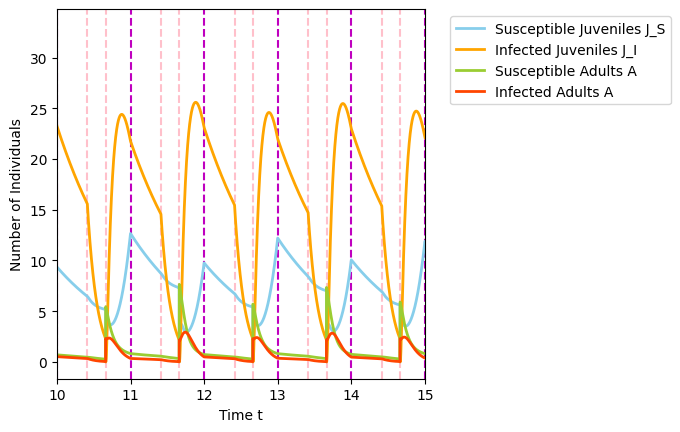

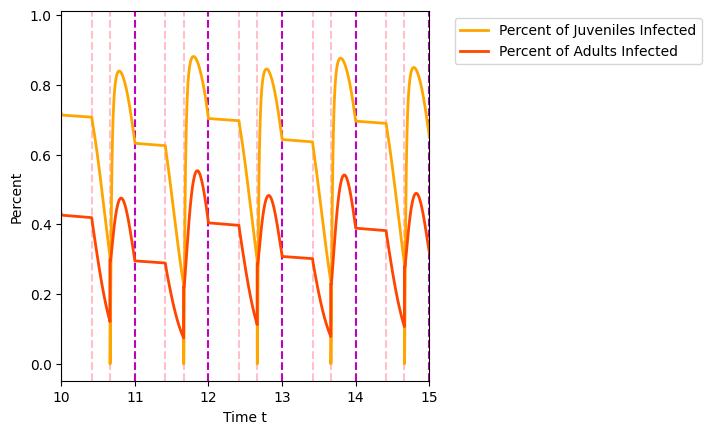

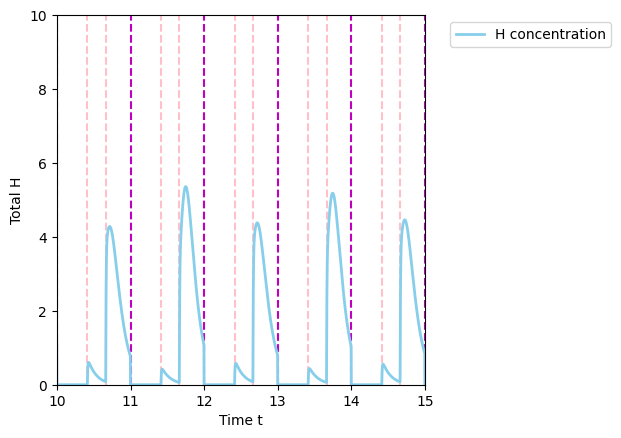

Final J_S:  10.886817290278062 crabs per 1000 meters squared
Final J_I:  22.631635796640644 crabs per 1000 meters squared
Final A_S:  0.7904546595732803 crabs per 1000 meters squared
Final A_I:  0.4279774865078171 crabs per 1000 meters squared
Final H:  0.9265800352891027 spores x 10^9
10.781952869001111 22.694512301036628 0.7943723158758778 0.434910579043318


In [40]:
# Plot susceptible juveniles, infected juveniles, adults, etc. versus time. Hematodinium is in different units, so it is not plotted
for t in range(len(Season_transitions)):
 plt.axvline(x = Season_transitions[t], color = 'pink', linestyle = 'dashed')
for t in range(years):
  plt.axvline(x = t, color = 'm', linestyle = 'dashed')
plt.plot(Total_time, TotalJ_S, linewidth=2, color='skyblue', label="Susceptible Juveniles J_S")
plt.plot(Total_time, TotalJ_I, linewidth=2, color='orange', label="Infected Juveniles J_I")
plt.plot(Total_time, TotalA_S, linewidth=2, color='yellowgreen', label="Susceptible Adults A")
plt.plot(Total_time, TotalA_I, linewidth=2, color='orangered', label="Infected Adults A")
plt.xlabel("Time t")
plt.xlim(10, 15) #Choose a smaller range of years to plot
plt.ylabel("Number of Individuals")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #Plot legend
plt.subplots_adjust(right=0.7)
plt.show()

# Plot % infecteds versus time
for t in range(len(Season_transitions)):
 plt.axvline(x = Season_transitions[t], color = 'pink', linestyle = 'dashed')
for t in range(years):
  plt.axvline(x = t, color = 'm', linestyle = 'dashed')
plt.plot(Total_time, TotalJ_percent, linewidth=2, color='orange', label="Percent of Juveniles Infected")
plt.plot(Total_time, TotalA_percent, linewidth=2, color='orangered', label="Percent of Adults Infected")
plt.xlabel("Time t")
plt.xlim(10, 15) #Choose a smaller range of years to plot
plt.ylabel("Percent")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #Plot legend
plt.subplots_adjust(right=0.7)
plt.show()

# Plot H versus time
for t in range(len(Season_transitions)):
    plt.axvline(x=Season_transitions[t], color='pink', linestyle='dashed')
for t in range(years):
    plt.axvline(x=t, color='m', linestyle='dashed')

plt.plot(Total_time, TotalH_L, linewidth=2, color='skyblue', label="H concentration")
plt.xlabel("Time t")
plt.xlim(10, 15)  # Zoom in on a smaller range of years
plt.ylim(0, 10)   # Set consistent y-axis scale
plt.ylabel("Total H")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.7)
plt.show()

#Print final values of each variable for entire range of years simulated
print("Final J_S: ", TotalJ_S.pop(), "crabs per 1000 meters squared")
print("Final J_I: ", TotalJ_I.pop(), "crabs per 1000 meters squared")
print("Final A_S: ", TotalA_S.pop(), "crabs per 1000 meters squared")
print("Final A_I: ", TotalA_I.pop(), "crabs per 1000 meters squared")
print("Final H: ", TotalH_L.pop(), "spores x 10^9")
print(TotalJ_S.pop(),TotalJ_I.pop(),TotalA_S.pop(),TotalA_I.pop())

In [70]:
### Hyperbolic Fishing ###

#Winter Parameters
#m_wj = Natural mortality of juveniles in winter
#m_wa = Natural mortality of adults in winter
#d_w = Disease related mortality in winter

#Define winter rates of change
def deriv_w(w,t,m_wj,m_wa,d_w): #w is the vector [J_S,J_I,A_S,A_I,H]; t is time
  J_S, J_I, A_S, A_I, H = w
  dJ_S = - m_wj*J_S
  dJ_I = - m_wj*J_I - d_w*J_I
  dA_S = - m_wa*A_S
  dA_I = - m_wa*A_I - d_w*A_I
  dH = 0
  return [dJ_S,dJ_I,dA_S,dA_I,dH]

#Spring Parameters
#p = Density of predators
#k_s = Maximum feeding rate in spring
#Gamma = Raised susceptibility of infected juveniles to cannibalism and predation
#J_x = Prey density at half of maximum feeding rate
#d_s = Disease related mortality in spring
#m_sa = Natural mortality of adults in spring
#f_ah = maximum fishing mortality rate
#f_al = linear fishing mortality rate
#s = adult density at half of the maximum fishing rate
#c_sj = Juvenile infection rate in spring
#c_sa = Adult infection rate in spring
#r_j = Dinospore shedding rate for juveniles
#r_a = Dinospore shedding rate for adults
#Delta = Dinosopore removal rate
#x = percentage of adult infecteds still fished

#Fishing functions, (used in both Spring and Fall)
def fishing_hyp(t,A_S,A_I,f_ah,s):
  A_all = A_S+A_I
  F_H = (f_ah * A_all)/(1+ s*A_all)
  return F_H

def fishing_lin(t, A_S, A_I, f_al, s):
  A_all = A_S+A_I
  F_L = (f_ah*A_all)/(s+A_all)
  return F_L

#Define spring rates of change
def deriv_s(w,t,p,k_s,Gamma,J_x,d_s,m_sa,f_ah,f_al,s,c_sj,c_sa,r_j,r_a,Delta):
  J_S, J_I, A_S, A_I, H = w   #Again, w is the vector [J_S,J_I,A_S,A_I,H]; t is time
  dJ_S = - (p + A_S + A_I)*(k_s*(J_S + Gamma*J_I))/(J_x**2 + (J_S + Gamma*J_I)**2)*J_S - c_sj*J_S*H#in spring, change back to H as just H, death rate from OG model above, shouldn't be a function, get rid of g(H) in H'
  dJ_I = - (p + A_S + A_I)*(k_s*(J_S + Gamma*J_I))/(J_x**2 + (J_S + Gamma*J_I)**2)*Gamma*J_I + c_sj*J_S*H - d_s*J_I #go back to linear transmission as well??
  dA_S = - m_sa*A_S - fishing_hyp(t,A_S,A_I,f_ah,s)*(A_S)/(A_S + A_I) - c_sa*A_S*H
  dA_I = - m_sa*A_I - fishing_hyp(t,A_S,A_I,f_ah,s)*(A_I*(1-x))/(A_S + A_I) + c_sa*A_S*H - d_s*A_I
  dH = r_j*J_I + r_a*A_I - Delta*H
  return [dJ_S,dJ_I,dA_S,dA_I,dH]

#Fall Parameters
#p = Density of predators
#k_f = Maximum feeding rate in fall
#Gamma = Raised susceptibility of infected juveniles to cannibalism and predation
#J_x = Prey density at half of maximum feeding rate
#d_f = Disease related mortality in fall
#m_fa = Natural mortality in fall
#f_ah = maximum fishing mortality rate
#f_al = linear fishing mortality rate
#s = adult density at half of the maximum fishing rate
#c_fj = Juvenile infection rate in fall
#c_fa = Adult infection rate in fall
#r_j = Dinospore shedding rate for juveniles
#r_a = Dinospore shedding rate for adults
#Delta = Dinosopore removal rate
#alpha = maximum per capita reproduction rate
#beta = density-dependent effect on reproduction
#x = percentage of adult infecteds still fished

#Recruitment function
def recruitment(t,A_S, A_I,alpha,beta):
  #total_recruits = (alpha*A_S) / (1+b*A_S**2) , the Ricker function version
  A_all = A_S+A_I
  total_recruits = (alpha*(A_all))/(beta+(A_all)) #hyperbolic, what we use
  rec_distributed = total_recruits / t_f
  return rec_distributed

#Define fall rates of change
def deriv_f(w,t,p,k_f,Gamma,J_x,d_f,m_fa,f_ah,f_al,s,c_fj,c_fa,r_j,r_a,Delta,alpha,beta):
  J_S, J_I, A_S, A_I, H = w    #Again, w is the vector [J_S,J_I,A_S,A_I,H]; t is time
  dJ_S = recruitment(t,A_S,A_I,alpha,beta) - (p + A_S + A_I)*(k_f*(J_S + Gamma*J_I))/(J_x**2 + (J_S + Gamma*J_I)**2)*J_S - c_fj*J_S*H
  dJ_I = - (p + A_S + A_I)*(k_f*(J_S + Gamma*J_I))/(J_x**2 + (J_S + Gamma*J_I)**2)*Gamma*J_I + c_fj*J_S*H - d_f*J_I
  dA_S = - m_fa*A_S - fishing_hyp(t,A_S,A_I,f_ah,s)*(A_S)/(A_S + A_I) - c_fa*A_S*H
  dA_I = - m_fa*A_I - fishing_hyp(t,A_S,A_I,f_ah,s)*(A_I*(1-x))/(A_S + A_I) + c_fa*A_S*H - d_f*A_I
  dH = r_j*J_I + r_a*A_I - Delta*H
  return [dJ_S,dJ_I,dA_S,dA_I,dH]

#Functions to generate disease prevalence graphs
def safe_J_percent(J_S, J_I): #Prevalence for juveniles
    mask = (J_S + J_I) != 0 # Check if denominator (J_S + J_I) is zero
    # Calculate J_I percent only for non-zero denominator elements
    J_percent = np.zeros_like(J_I)
    J_percent[mask] = J_I[mask] / (J_S[mask] + J_I[mask])
    return J_percent

def safe_A_percent(A_S, A_I): #Prevalence for adults
    mask = (A_S + A_I) != 0
    A_percent = np.zeros_like(A_I)
    A_percent[mask] = A_I[mask] / (A_S[mask] + A_I[mask])
    return A_percent


TotalJ_S = [] #Empty lists, will hold all of the variable values and the time steps for graphing
TotalJ_I = []
TotalA_S = []
TotalA_I = []
TotalH_H = []
Total_time = []
TotalJ_percent_H = []
TotalA_percent_H = []
Season_transitions = []

t_w = 151/365 #Proportion of days out of the year in each season (w=winter, s=spring, f=fall)
t_s = 91/365
t_f = 123/365
num_seasons = 3  #Number of seasons in a year
season_lengths = [t_w, t_s, t_f]  #Duration of each season
season_ends = [0, t_w, (t_w + t_s)] #End of each season interval, used for time steps and initial conditions
years = 50 #Number of years simulated

for year in range(years):
    #Calculation of time steps and season transitions
    for season in range(num_seasons):
      t = year + season_ends[season]
      time = np.linspace(t, t + season_lengths[season], 200)  # Time range for each season
      time2 = [t, t + season_lengths[season]] # Time range for each season

      #Winter initial conditions
      if season == 0 and t == 0: #First year, first winter (year 0) initial conditions
        w0 = [1.4954160801296652, 10.01313319909174, 0.11611118423767798, 1.3643661339726547, 0]
      elif season == 0 and t != 0: #Continuity during the winter season, as well as initial conditions for year 1, year 2, year 3,... winters
        w0 = [J_S[-1], J_I[-1], A_S[-1], A_I[-1], 0]

      #Spring initial conditions
      elif season == 1 and (t - year) == t_w:
        w0 = [J_S[-1], J_I[-1], A_S[-1], A_I[-1], 0]
        Season_transitions.append(t)
      elif season == 1 and (t - year) != t_w: #Continuity during the spring season
        w0 = [J_S[-1], J_I[-1], A_S[-1], A_I[-1], H[-1]]
        Season_transitions.append(t)

      #Fall initial conditions
      elif abs(t - year - season_ends[1]) >= 1e-17 and season == 2:
        w0 = [0, 0, A_S[-1]+J_S[-1], A_I[-1]+J_I[-1], H[-1]]
        Season_transitions.append(t)
      elif season == 2 and (t - year) != season_ends[1]: #Continuity during the fall season
        w0 = [J_S[-1], J_I[-1], A_S[-1], A_I[-1], H[-1]]
        Season_transitions.append(t)

      #Parameter input:
      #Winter:
      m_wj=0.9
      m_wa=0.9
      d_w=0.0718156732891 #either 0.74 for colder or 0.07 for warmer - determines if 1 or 2 cycles
      #graph of period change of theta and d_w shown in paper, maybe make this figure better
      #should be figure, not just dot, dw small = 1 period, dw large and theta small = 2 period
      #wants it to look like areas with roman numerals in diff colored polygon areas(I or II to show period type), show a curve to separate the regions

      #Spring:
      p=20
      k_s=5
      Gamma=0.8
      J_x=80
      m_sa=0.9
      f_ah= 0.5362 #new f for hyp 2, 37/69
      f_al=0.294 #f for lin
      s=0.0145 #new s for hyp 2, 1/69
      c_sj=2.5
      c_sa=1.3
      r_j=.9125
      r_a=328.5
      Delta=182.5
      d_s=8.151
      x=0.1

      #Fall:
      p=20
      k_f=5
      Gamma=0.8
      J_x=80
      d_f=11.114
      m_fa=0.9
      f_ah= 0.5362 #new f for hyp 2, same as spring
      f_al=0.294 #f for lin, same as spring
      s=0.0145 #new s for hyp 2, same as spring
      c_fj=22
      c_fa=1.7
      r_j=.9125
      r_a=328.5
      Delta=182.5
      alpha=122.388
      beta=0.3143
      x=0.1

      #Solve system of ODEs
      if (t - year) >= 0 and (t - year) <= t_w and season == 0: #Winter seasons (i.e. t = [0,t_w], [1,1+t_w], [2,2+t_w]...)
          wsol = odeint(deriv_w,w0,time,args=(m_wj,m_wa,d_w))  #Solve winter ODE
          J_S, J_I, A_S, A_I, H = wsol.T
          J_percent = safe_J_percent(J_S, J_I) #Calculate disease prevalences
          A_percent = safe_A_percent(A_S, A_I)
          J_S = np.ndarray.tolist(J_S) #Turn arrays into lists so we can concatenate
          J_I = np.ndarray.tolist(J_I)
          A_S = np.ndarray.tolist(A_S)
          A_I = np.ndarray.tolist(A_I)
          H = np.ndarray.tolist(H)
          J_percent = np.ndarray.tolist(J_percent)
          A_percent = np.ndarray.tolist(A_percent)
          time = np.ndarray.tolist(time)
          TotalJ_S += J_S[:-1] #Continuity, remove the overlapping points for when we put all of the values from all the integrations together
          TotalJ_I += J_I[:-1]
          TotalA_S += A_S[:-1]
          TotalA_I += A_I[:-1]
          TotalH_H += H[:-1]
          TotalJ_percent_H += J_percent[:-1]
          TotalA_percent_H += A_percent[:-1]
          Total_time += time[:-1] #remove duplicate time steps
      elif t >= t_w and t <= season_ends[1] and season == 1: #Year 0 spring (calculated separately due to fractional values for t_w, t_s, t_f)
          wsol = odeint(deriv_s,w0,time,args=(p,k_s,Gamma,J_x,d_s,m_sa,f_ah,f_al,s,c_sj,c_sa,r_j,r_a,Delta))  #Solve spring ODE
          J_S, J_I, A_S, A_I, H = wsol.T
          J_percent = safe_J_percent(J_S, J_I) #Calculate disease prevalences
          A_percent = safe_A_percent(A_S, A_I)
          J_S = np.ndarray.tolist(J_S) #Turn arrays into lists so we can concatenate
          J_I = np.ndarray.tolist(J_I)
          A_S = np.ndarray.tolist(A_S)
          A_I = np.ndarray.tolist(A_I)
          H = np.ndarray.tolist(H)
          J_percent = np.ndarray.tolist(J_percent)
          A_percent = np.ndarray.tolist(A_percent)
          time = np.ndarray.tolist(time)
          TotalJ_S += J_S[:-1] #Continuity, remove the overlapping points
          TotalJ_I += J_I[:-1]
          TotalA_S += A_S[:-1]
          TotalA_I += A_I[:-1]
          TotalH_H += H[:-1]
          TotalJ_percent_H += J_percent[:-1]
          TotalA_percent_H += A_percent[:-1]
          Total_time += time[:-1] #remove duplicate time steps
      elif abs(t - year - t_w) >= 1e-17 and abs(t - year - season_ends[1]) >= 1e-17 and season == 1: #All other spring seasons (i.e. t = [1+t_w,1+t_w+t_s], [2+t_w,2+t_w+t_s]...); difference is the increased flexibility for the elif condition
          wsol = odeint(deriv_s,w0,time,args=(p,k_s,Gamma,J_x,d_s,m_sa,f_ah,f_al,s,c_sj,c_sa,r_j,r_a,Delta))  #Solve spring ODE
          J_S, J_I, A_S, A_I, H = wsol.T
          J_percent = safe_J_percent(J_S, J_I) #Calculate disease prevalences
          A_percent = safe_A_percent(A_S, A_I)
          J_S = np.ndarray.tolist(J_S) #Turn arrays into lists so we can concatenate
          J_I = np.ndarray.tolist(J_I)
          A_S = np.ndarray.tolist(A_S)
          A_I = np.ndarray.tolist(A_I)
          H = np.ndarray.tolist(H)
          J_percent = np.ndarray.tolist(J_percent)
          A_percent = np.ndarray.tolist(A_percent)
          time = np.ndarray.tolist(time)
          TotalJ_S += J_S[:-1] #Continuity, remove the overlapping points
          TotalJ_I += J_I[:-1]
          TotalA_S += A_S[:-1]
          TotalA_I += A_I[:-1]
          TotalH_H += H[:-1]
          TotalJ_percent_H += J_percent[:-1]
          TotalA_percent_H += A_percent[:-1]
          Total_time += time[:-1] #remove duplicate time steps
      elif abs(t - year - season_ends[1]) >= 1e-17 and abs(t - year - 1) >= 1e-17 and season == 2: #Fall seasons (i.e. t = [t_w+t_s,1], [1+t_w+t_s,2], [2+t_w+t_s,3]...)
          wsol = odeint(deriv_f,w0,time,args=(p,k_f,Gamma,J_x,d_f,m_fa,f_ah,f_al,s,c_fj,c_fa,r_j,r_a,Delta,alpha,beta))  #Solve fall ODE
          J_S, J_I, A_S, A_I, H = wsol.T
          J_percent = safe_J_percent(J_S, J_I)
          A_percent = safe_A_percent(A_S, A_I)
          J_S = np.ndarray.tolist(J_S) #Turn arrays into lists so we can concatenate
          J_I = np.ndarray.tolist(J_I)
          A_S = np.ndarray.tolist(A_S)
          A_I = np.ndarray.tolist(A_I)
          H = np.ndarray.tolist(H)
          J_percent = np.ndarray.tolist(J_percent)
          A_percent = np.ndarray.tolist(A_percent)
          time = np.ndarray.tolist(time)
          TotalJ_S += J_S[:-1] #Continuity, remove the overlapping points
          TotalJ_I += J_I[:-1]
          TotalA_S += A_S[:-1]
          TotalA_I += A_I[:-1]
          TotalH_H += H[:-1]
          TotalJ_percent_H += J_percent[:-1]
          TotalA_percent_H += A_percent[:-1]
          Total_time += time[:-1] #remove duplicate time steps
# Determine the indices of season transitions in lists
season_indices = [min(range(len(Total_time)), key=lambda i: abs(Total_time[i] - t)) for t in Season_transitions]

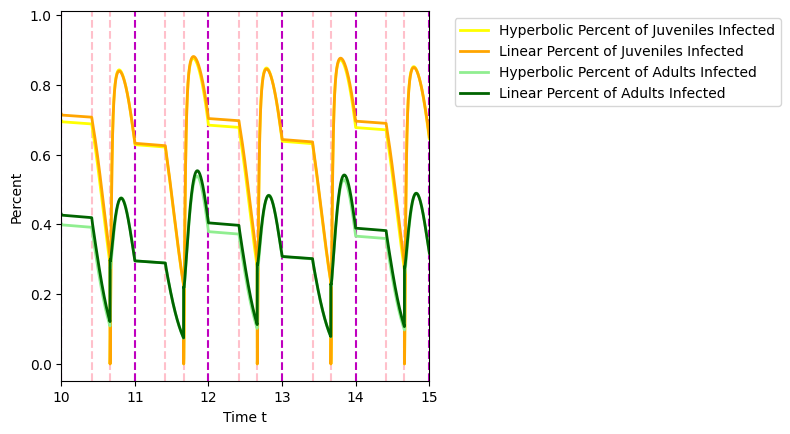

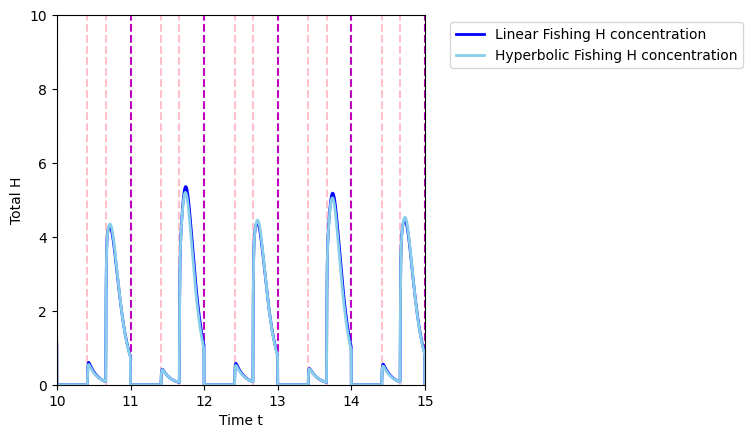

Final J_S:  11.344465770914638 crabs per 1000 meters squared
Final J_I:  22.290830626975758 crabs per 1000 meters squared
Final A_S:  0.7710668858304457 crabs per 1000 meters squared
Final A_I:  0.3975848010206887 crabs per 1000 meters squared
Final Linear H:  0.9265800352891027 spores x 10^9
Final Hyperbolic H:  0.8678500789239838 spores x 10^9


In [71]:
### Hyperbolic vs Linear graphs ###

#percent infected graph
for t in range(len(Season_transitions)):
 plt.axvline(x = Season_transitions[t], color = 'pink', linestyle = 'dashed')
for t in range(years):
  plt.axvline(x = t, color = 'm', linestyle = 'dashed')
plt.plot(Total_time, TotalJ_percent_H, linewidth=2, color='yellow', label="Hyperbolic Percent of Juveniles Infected")
plt.plot(Total_time, TotalJ_percent_L, linewidth=2, color='orange', label="Linear Percent of Juveniles Infected")
plt.plot(Total_time, TotalA_percent_H, linewidth=2, color='#90EE90', label="Hyperbolic Percent of Adults Infected")
plt.plot(Total_time, TotalA_percent_L, linewidth=2, color='#006400', label="Linear Percent of Adults Infected")
plt.xlabel("Time t")
plt.xlim(10, 15) #Choose a smaller range of years to plot
plt.ylabel("Percent")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #Plot legend
plt.subplots_adjust(right=0.7)
plt.show()

#H concentration graph
for t in range(len(Season_transitions)):
    plt.axvline(x=Season_transitions[t], color='pink', linestyle='dashed')
for t in range(years):
    plt.axvline(x=t, color='m', linestyle='dashed')

plt.plot(Total_time, TotalH_L, linewidth=2, color='blue', label="Linear Fishing H concentration")
plt.plot(Total_time, TotalH_H, linewidth=2, color='skyblue', label="Hyperbolic Fishing H concentration")
plt.xlabel("Time t")
plt.xlim(10, 15)  # Zoom in on a smaller range of years
plt.ylim(0, 10)   # Set consistent y-axis scale
plt.ylabel("Total H")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.7)
plt.show()

#Print final values of each variable for entire range of years simulated
print("Final J_S: ", TotalJ_S.pop(), "crabs per 1000 meters squared")
print("Final J_I: ", TotalJ_I.pop(), "crabs per 1000 meters squared")
print("Final A_S: ", TotalA_S.pop(), "crabs per 1000 meters squared")
print("Final A_I: ", TotalA_I.pop(), "crabs per 1000 meters squared")
print("Final Linear H: ", TotalH_L.pop(), "spores x 10^9")
print("Final Hyperbolic H: ", TotalH_H.pop(), "spores x 10^9")